## Morphology Types Classification

In [1]:
# importing packages

#Versions used:-
# Python:- 3.5.1
# OS:- Windows 10

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
from time import time

from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, models, transforms
import os
import time
from PIL import Image

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_recall_fscore_support
import skimage.exposure
from skimage.feature import hog

In [2]:
# Obtaining the count of actual number of images (orginial images relative path = 'modified_data_1//')
count = 0;
for root, directories, filenames in os.walk('modified_data_1//'):
    for filename in filenames: 
        count = count + 1
print(count)

138


In [3]:
# Resizing all the images to (224, 224) for alexnet (stored in relative path = 'final_data_1//')

data_path = 'final_data_1//'
for root, directories, filenames in os.walk('modified_data_1//'):
    for filename in filenames: 
        img = Image.open(os.path.join(root+ '//' +filename))
        new_img = img.resize((224,224))
        new_root = data_path + root[15:]
        new_img.save(os.path.join(new_root + '//' +filename), "JPEG", optimize=True)

In [4]:
# Cropping the original images into 4 equal parts (to generate more data as original pixel density is good)
# Storing the images in the same folder ('final_data_1//')

def crop(im, height, width):
    imgwidth, imgheight = im.size
    for i in range(int(imgheight // height)):
        for j in range(int(imgwidth // width)):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield im.crop(box)

if __name__=='__main__':
    data_path = 'final_data_1//'
    for root, directories, filenames in os.walk('modified_data_1//'):
        for filename in filenames:
            im = Image.open(os.path.join(root + '//' +filename))
            imgwidth, imgheight = im.size
            
            height = imgheight/2
            width =  imgwidth/2
            start_num = 0
            for k, piece in enumerate(crop(im, height, width), start_num):
                img = Image.new('RGB', (int(width), int(height)), 255)
                
                img.paste(piece)
                new_root = data_path + root[15:] 
                path = os.path.join(new_root + '//' + filename + "_%d.jpg" %int(k+1))
                img.save(path)

In [5]:
# Count of the total images after croping and resizing

count = 0;
for root, directories, filenames in os.walk('final_data_1//'):
    for filename in filenames: 
        count = count + 1
print(count)

690


## Approach 2 - Data Augmentation and Pre-trained model

In [6]:
# Storing the class names and id in a dictionary

class_names = [name[17:] for name in glob.glob('final_data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

{0: 'hf_con', 1: 'hf_dec', 2: 'hf_mix', 3: 'mf_con', 4: 'mf_dec', 5: 'mf_mix'}


In [44]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]


# ==========================================
#      Random Rotate Data Augmentation
# ==========================================
def random_rotation(image_array):
    image_array1 = image_array.astype(np.uint8)
    # pick a random degree of rotation between 90 degress on the left and 90 degrees on the right
    random_degree = random.uniform(-90, 90)
    return sk.transform.rotate(image_array1, random_degree)

# ==========================================
#      Random Crop Data Augmentation
# ==========================================
def randomCrop(img, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    x = random.randint(0, img.shape[1] - width)
    y = random.randint(0, img.shape[0] - height)
    img = img[y:y+height, x:x+width]
    return img


# ==========================================
#           Loading Data 
# ==========================================
def load_dataset(path, img_size, batch_num=1, shuffle=False, augment=False, norm=False, rotate = False, crop = False):
    
    data = []
    labels = []
    
    channel_num = 3
    
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            img = cv2.imread(filename)
            img = cv2.resize(img, img_size, cv2.INTER_AREA)
            img = np.transpose(img, [2, 0, 1])
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
    # norm data to zero-centered
    if norm:
        print("Includes normalizing")
        mean_img = np.mean(np.array(data), 0)
        data = data - mean_img
        data = [data[i] for i in range(data.shape[0])]
    
    # augment data
    if augment:
        print("Includes augmentation(vertically flipping images)")
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)
        
    #rotate data    
    if rotate:
        print("Includes rotated images")
        rot_data = [random_rotation(img) for img in data]
        data.extend(rot_data)
        labels.extend(labels)
        
    #crop data    
    if crop:
        print("Includes random cropping")
        crop_data = [randomCrop(img, 112, 112) for img in data]
        crop_resize = [cv2.resize(img, (224, 224), cv2.INTER_LINEAR) for img in crop_data]
        data.extend(crop_resize)
        labels.extend(labels)
        
    
    # randomly permute (before training)
    if shuffle:
        print("Includes shuffling images")
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
        
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d).float())

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

In [45]:
# Defining image size and batch size
img_size = (224, 224) 
batch_num = 26

# load training dataset
trainloader_large = list(load_dataset('final_data_1/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, norm=True, rotate = True, crop = False))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('final_data_1/test/', img_size, batch_num=batch_num))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Includes normalizing
Includes augmentation(vertically flipping images)
Includes rotated images
Includes shuffling images
2240
Finish loading 86 minibatches(=26) of training samples.
130
Finish loading 5 minibatches(=26) of testing samples.


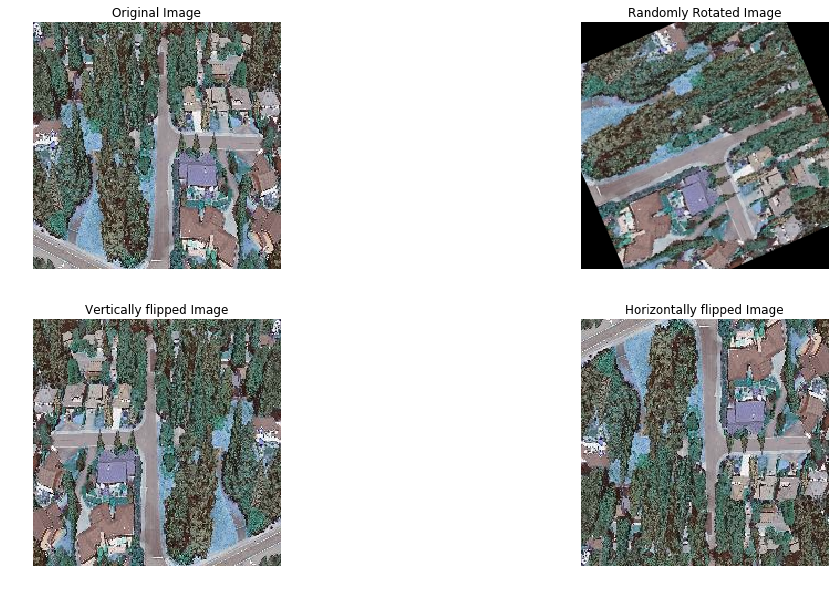

In [60]:
display_img = 'final_data_1/train/hf_con/SUB_HF_CON_2_SP.jpg'

orig_img = cv2.imread(display_img)
orig_img = cv2.resize(orig_img, img_size, cv2.INTER_AREA)


ver_img = np.flip(orig_img, 1)
hor_img = np.flip(orig_img, 0)
rot_img = random_rotation(orig_img)

images = [orig_img, rot_img, ver_img, hor_img]

labels = ["Original Image", "Randomly Rotated Image", "Vertically flipped Image", "Horizontally flipped Image"]
fig=plt.figure(figsize=(18, 10))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(labels[i-1])
    plt.imshow(img)
plt.show()

In [25]:
# Using pre-trained model (Alexnet architecture)

# Using last layer as features  

model_ft = models.alexnet(pretrained=True)

# Using penultimate layer as features

# model = models.alexnet(pretrained=True)
# model.classifier = nn.Sequential(*list(model.classifier.children())[:-2]) 
# device = torch.device('cpu')
# model_fc7 = model.to(device)

last_layer = 1000
train_labels = []
train_act = np.empty(shape=[0, last_layer])


for i, data in enumerate(trainloader_large, 0):
        inputs, labels = data
        outputs = model_ft(inputs)
        #outputs = model_fc7(inputs)
        
        train_act = np.vstack((train_act,outputs.detach().numpy().reshape(batch_num, last_layer)))
        train_labels.append(labels.detach().numpy())

In [26]:
# Training using SVM

print(train_act.shape)
l=[]
for i in train_labels:
    for j in i:
        l.append(j)
l= np.asarray(l).flatten()
print(l.shape)

since = time.time()

clf = SVC(max_iter=1000)
clf.fit(train_act, l)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

(2236, 1000)
(2236,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Training complete in 0m 12s


In [27]:
# Testing using SVM

since = time.time()
predicted_labels = []
test_labels = []

model_ft.eval()
#model.eval()
for i, data in enumerate(testloader_large, 0):
    
        inputs, labels = data
        outputs = model_ft(inputs)
        #outputs = model(inputs)

        test_pred = clf.predict(outputs.detach().numpy().reshape(batch_num,last_layer))
        predicted_labels.append(test_pred)
        
        test_labels.append(labels.detach().numpy())


pred = []    
for i in predicted_labels:
    for j in i:
        pred.append(j)

test_l = []    
for i in test_labels:
    for j in i:
        test_l.append(j)


count=0
for i in range(len(pred)):
    if pred[i] == test_l[i]:
        count = count + 1

accuracy = ((count*1.0) / len(test_l))*100
print("Accuracy(%):-" + str(accuracy))
print("precision, recall, f1 score: ", precision_recall_fscore_support(test_l, pred, average='weighted'))
time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Accuracy(%):-35.38461538461539
precision, recall, f1 score:  (0.47179040471723405, 0.35384615384615387, 0.3468174566368668, None)
Testing complete in 0m 7s


## Approach 3 (Fine tuning last layer of pre-trained model)

In [62]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

# Setting image size, batch size and number of classes
img_size = (224, 224)
batch_size = 26
num_classes = 6

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    model_ft = models.alexnet(pretrained=use_pretrained)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size


# Initializing the model
model_ft, input_size = initialize_model(num_classes, feature_extract = True, use_pretrained=True)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [63]:
# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join('final_data_1/', x), data_transforms[x]) for x in ['train', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

Initializing Datasets and Dataloaders...


In [43]:
model_ft = model_ft.to('cpu')

feature_extract = False
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

learning_rate = 0.003
optimizer_ft = optim.SGD(params_to_update, lr = learning_rate, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


In [44]:
# Model Training

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    for epoch in range(1,num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        phase = 'train'
        model.train()  # Setting model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterating over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset))*100

        print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [45]:
# Model Testing

def test_model(model , dataloaders):
    model.eval()
    since = time.time()
    total = 0
    correct = 0
    phase = 'test'
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_acc = ((correct*1.0) / len(dataloaders['test'].dataset)) *100

    print('{} Acc: {:.4f}%'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
#     return model

In [46]:
# Loss function
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training and evaluatation
model_ft  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 1.7580 Acc: 27.6786%
Epoch 2/10
----------
train Loss: 1.4546 Acc: 38.0357%
Epoch 3/10
----------
train Loss: 1.3914 Acc: 38.7500%
Epoch 4/10
----------
train Loss: 1.2811 Acc: 48.9286%
Epoch 5/10
----------
train Loss: 1.2840 Acc: 43.5714%
Epoch 6/10
----------
train Loss: 1.2157 Acc: 50.7143%
Epoch 7/10
----------
train Loss: 1.2386 Acc: 46.9643%
Epoch 8/10
----------
train Loss: 1.1409 Acc: 51.9643%
Epoch 9/10
----------
train Loss: 1.1346 Acc: 54.8214%
Epoch 10/10
----------
train Loss: 1.0462 Acc: 57.1429%
Training complete in 13m 2s


In [47]:
# Testing
test_model(model_ft, dataloaders_dict)

test Acc: 39.2308%
Testing complete in 0m 9s


In [65]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 130
     Root Location: final_data_1/test
     Transforms (if any): Compose(
                              Resize(size=224, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'train': Dataset ImageFolder
     Number of datapoints: 560
     Root Location: final_data_1/train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              RandomVerticalFlip(p=0.5)
                              RandomRotation(degrees=(-90, 90), resample=False, expand=False)
                              ToTensor()
  

## Approach 1 (Histogram of gradients as features and SVM) 

In [12]:
class_names = [name[19:] for name in glob.glob('final_data_1/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

{0: 'hf_con', 1: 'hf_dec', 2: 'hf_mix', 3: 'mf_con', 4: 'mf_dec', 5: 'mf_mix'}


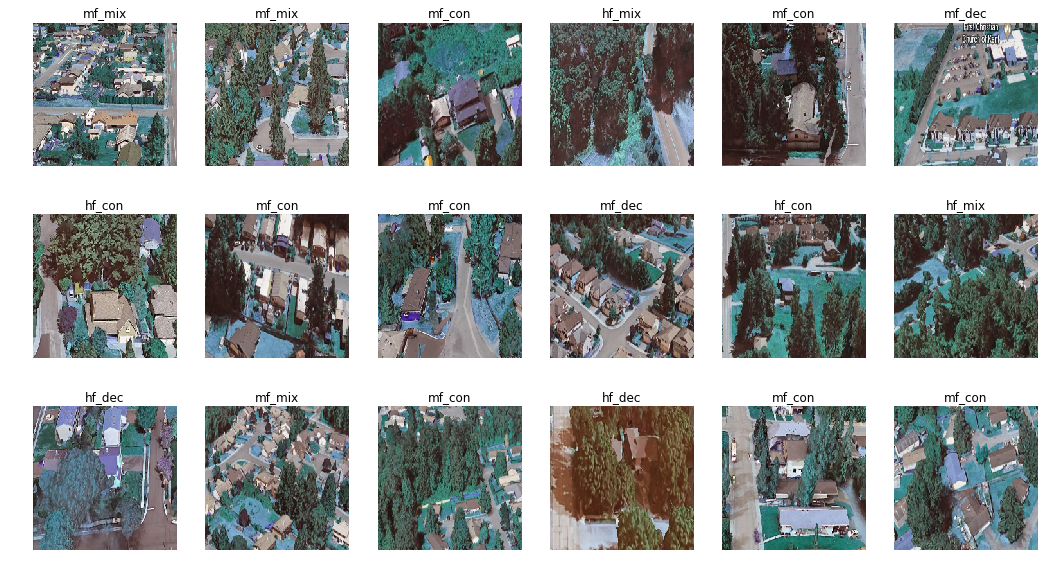

In [13]:
# load data
images_list = []   # List of images
labels_list = []   # List of labels for each image
file_source1 = 'final_data_1/train/'
file_source2 = 'final_data_1/test/'

def loadData(file, img_size):
    for id, class_name in class_names.items():
            img_path_class = glob.glob(file + class_name + '/*.jpg')
            labels_list.extend([id]*len(img_path_class))
            for filename in img_path_class:
                img = cv2.imread(filename)
                img = cv2.resize(img, img_size, cv2.INTER_AREA)
                images_list.append(img)


img_size = (224, 224)
loadData(file_source1, img_size)
loadData(file_source2, img_size)

# Shuffling the images and the corresponding labels
z = list(zip(images_list, labels_list))
random.shuffle(z)
images_list, labels_list = zip(*z)


# Displaying 18 random images
fig=plt.figure(figsize=(18, 10))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    img = images_list[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(class_names[labels_list[i-1]])
    plt.imshow(img)
plt.show()

labels_list = np.array(labels_list)
images_list = np.array(images_list)

c:\scikit-image\skimage\feature\_hog.py:247: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


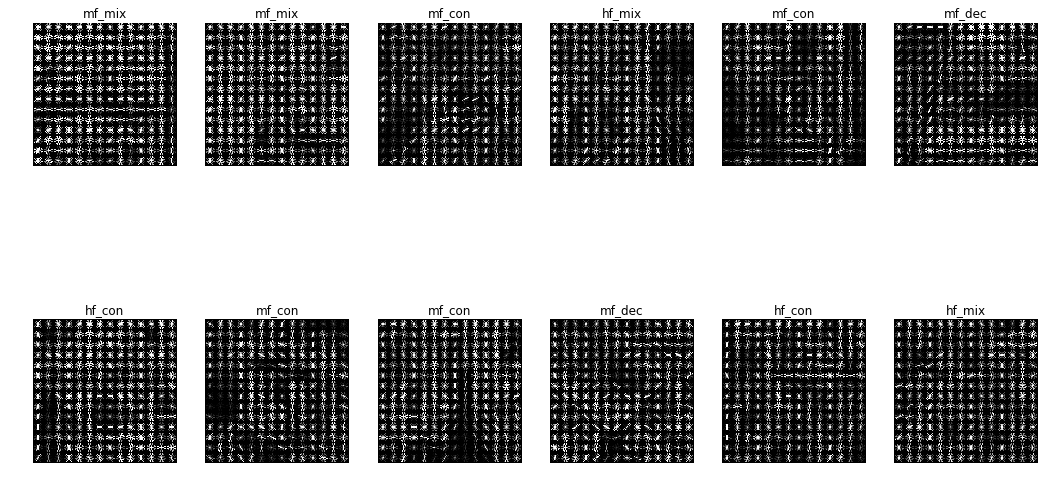

(552,)
(138,)


In [14]:
# Computing HOG features for the images

def computeHOGfeatures():
    HoG = []
    hog_features = []
    for i in range(1, 691):
        fd, hog_image = hog(images_list[i-1], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True, block_norm='L1', multichannel=True)
        
        hog_image_rescaled = skimage.exposure.rescale_intensity(hog_image, in_range=(0, 10))
        HoG.append(hog_image_rescaled)
        hog_features.append(fd)
    return HoG, hog_features
    
HoG, hog_features = computeHOGfeatures() 

fig=plt.figure(figsize=(18, 10))
columns = 6
rows = 2
for i in range(1, columns*rows +1):
    img = HoG[i-1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(class_names[labels_list[i-1]])
    plt.imshow(img, cmap='gray')
plt.show()


hog_features = np.array(hog_features)


images_train = hog_features[:552]
labels_train = labels_list[:552]

images_test = hog_features[552:]
labels_test = labels_list[552:]

print(labels_train.shape)
print(labels_test.shape)

In [22]:
# training model with SVM

clf = LinearSVC()
clf.fit(images_train,labels_train)
predict_labels = clf.predict(images_test)


mask = predict_labels==labels_test
correct = np.count_nonzero(mask)

#print('estimated labels: ',predict_labels)
#print('ground truth labels: ', labels_test) 
print('Accuracy: ',correct*100.0/predict_labels.size)
print("precision, recall, f1 score: ", precision_recall_fscore_support(labels_test, predict_labels, average='weighted'))

Accuracy:  26.81159420289855
f1 score:  0.25423517524352696
precision, recall, f1 score:  (0.2666258861911036, 0.26811594202898553, 0.25423517524352696, None)
